In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(suppress=True) # hide scientfic notation

In [3]:
df = pd.read_pickle('datasets/CarPricesData.pkl') # preprocessed
df.head()

,Age,KM,Weight,HP,MetColor,CC,Doors,Price
0,23.0,46986,1165.0,90,1,2000.0,3,13500
1,23.0,72937,1165.0,90,1,2000.0,3,13750
2,24.0,41711,1165.0,90,1,2000.0,3,13950
3,26.0,48000,1165.0,90,0,2000.0,3,14950
4,30.0,38500,1170.0,90,0,2000.0,3,13750


In [4]:
X = df.drop(columns='Price')
y = df[['Price']]

In [5]:
from sklearn.preprocessing import StandardScaler

featScaler = StandardScaler()
targetScaler = StandardScaler()

X = featScaler.fit_transform(X)
y = targetScaler.fit_transform(y).flatten() # need 1 d

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1148, 7)
(1148,)
(287, 7)
(287,)


neural network

In [7]:
from tensorflow.keras.models import Sequential # nn is going to be in sequence
from tensorflow.keras.layers import Dense # a neural layer

In [9]:
model = Sequential()
model.add(Dense(units=5, activation='relu', input_dim=X_train.shape[1])) # 1st hidden layer( input shape is required)
model.add(Dense(units=5, activation='tanh')) # 2nd hidden layer
model.add(Dense(1)) # output layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 40        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 76 (304.00 Byte)
Trainable params: 76 (304.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model.compile?

Signature:
model.compile(
    optimizer='rmsprop',
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    jit_compile=None,
    pss_evaluation_shards=0,
    **kwargs,
)
Docstring:
Configures the model for training.

Example:

```python
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
```

Args:
    optimizer: String (name of optimizer) or optimizer instance. See
      `tf.keras.optimizers`.
    loss: Loss function. May be a string (name of loss function), or
      a `tf.keras.losses.Loss` instance. See `tf.keras.losses`. A loss
      function is any callable with the signature `loss = fn(y_true,
      y_pred)`, where `y_true` are the ground truth values, and
      `y_pred` are the model's predictions.
      `y_t

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=tf.keras.metrics.R2Score())
history = model.fit(X_train,  
                    y_train, 
                    batch_size=8, 
                    epochs=100, 
                    validation_split=.2,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/100
115/115 [==============================] - 1s 3ms/step - loss: 1.0679 - r2_score: -0.0297 - val_loss: 0.7239 - val_r2_score: 0.1800
Epoch 2/100
115/115 [==============================] - 0s 1ms/step - loss: 0.6837 - r2_score: 0.3407 - val_loss: 0.4672 - val_r2_score: 0.4708
Epoch 3/100
115/115 [==============================] - 0s 1ms/step - loss: 0.4408 - r2_score: 0.5750 - val_loss: 0.3204 - val_r2_score: 0.6371
Epoch 4/100
115/115 [==============================] - 0s 2ms/step - loss: 0.3238 - r2_score: 0.6877 - val_loss: 0.2566 - val_r2_score: 0.7093
Epoch 5/100
115/115 [==============================] - 0s 2ms/step - loss: 0.2723 - r2_score: 0.7374 - val_loss: 0.2258 - val_r2_score: 0.7442
Epoch 6/100
115/115 [==============================] - 0s 2ms/step - loss: 0.2390 - r2_score: 0.7696 - val_loss: 0.2059 - val_r2_score: 0.7667
Epoch 7/100
115/115 [==============================] - 0s 2ms/step - loss: 0.2118 - r2_score: 0.7958 - val_loss: 0.1940 - val_r2_score: 0.780

In [63]:
# already tested
def findBestParams(X_train, y_train, X_test, y_test):
    batch_sizes = [8,16,32,64]
    epoch_list = [20, 50, 100]
    resultsdf =[]
    sno = 0
    for bs in batch_sizes:
        for epochs in epoch_list:
            sno+=1
            model = Sequential()
            model.add(Dense(units=5, activation='relu', input_dim=X_train.shape[1], kernel_initializer='normal')) # 1st hidden layer( input shape is required)
            model.add(Dense(units=5, activation='tanh', kernel_initializer='normal')) # 2nd hidden layer
            model.add(Dense(1)) # output layer
            model.compile(loss='mean_squared_error', optimizer='adam')
            model.fit(X_train, y_train, batch_size=bs, epochs=epochs, verbose=0)
            accuracy = 100 - np.mean(100* (np.abs(y_test - model.predict(X_test))/y_test))
            print(f'{sno} -> batch: {bs}, epochs: {epochs}, accuracy: {accuracy}')
            resultsdf.append({
                'sno': sno,
                'bs': bs,
                'epochs':epochs,
                'acc': accuracy
            })
    
    return pd.DataFrame(resultsdf)

In [64]:
# already tested
findBestParams(X_train, y_train, X_test, y_test)

9/9 [==============================] - 0s 1ms/step
1 -> batch: 8, epochs: 20, accuracy: 66.72412005749095
9/9 [==============================] - 0s 1ms/step
2 -> batch: 8, epochs: 50, accuracy: 68.23634100899719
9/9 [==============================] - 0s 1ms/step
3 -> batch: 8, epochs: 100, accuracy: 73.49885053483656
9/9 [==============================] - 0s 1ms/step
4 -> batch: 16, epochs: 20, accuracy: 65.91162747765748
9/9 [==============================] - 0s 1ms/step
5 -> batch: 16, epochs: 50, accuracy: 65.00777014626647
9/9 [==============================] - 0s 1ms/step
6 -> batch: 16, epochs: 100, accuracy: 66.43275375633189
9/9 [==============================] - 0s 1ms/step
7 -> batch: 32, epochs: 20, accuracy: 64.63183048598059
9/9 [==============================] - 0s 2ms/step
8 -> batch: 32, epochs: 50, accuracy: 65.55419242800885
9/9 [==============================] - 0s 2ms/step
9 -> batch: 32, epochs: 100, accuracy: 65.45303054532123
9/9 [==============================] 

,sno,bs,epochs,acc
0,1,8,20,66.724120
1,2,8,50,68.236341
2,3,8,100,73.498851
3,4,16,20,65.911627
4,5,16,50,65.007770
5,6,16,100,66.432754
6,7,32,20,64.631830
7,8,32,50,65.554192
8,9,32,100,65.453031
9,10,64,20,64.444509


In [14]:
history.history.keys()

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])

In [16]:
metrics_df = pd.DataFrame(history.history)

<Axes: >

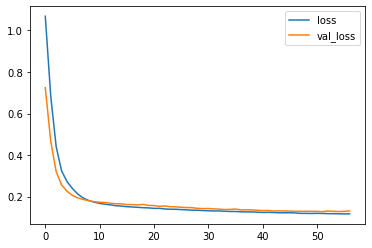

In [18]:
metrics_df[['loss', 'val_loss']].plot()

In [19]:
metrics_df.columns

Index(['loss', 'r2_score', 'val_loss', 'val_r2_score'], dtype='object')

<Axes: >

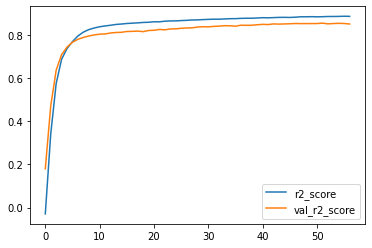

In [20]:
metrics_df[['r2_score', 'val_r2_score']].plot()

In [25]:
import os
model.save(os.path.join('models','car_price_prediction.keras'))

In [38]:
out = model.predict(np.array([X[0], X[50]]))
out.shape

1/1 [==============================] - 0s 17ms/step


(2, 1)

In [39]:
targetScaler.inverse_transform(out)

array([[15377.786],
       [17818.41 ]], dtype=float32)

In [45]:
df.columns.tolist()

['Age', 'KM', 'Weight', 'HP', 'MetColor', 'CC', 'Doors', 'Price']

In [67]:
# model, featscaler, targetscaler
def predict_price(age, km, wt, hp, mc, cc, doors):
    inp = pd.DataFrame({
        'Age':[age],
        'KM':[km],
        'Weight':[wt],
        'HP':[hp],
        'MetColor':[mc],
        'CC':[cc],
        'Doors':[doors]
    })
    scaled_inp = featScaler.transform(inp)
    out = model.predict(scaled_inp)
    return targetScaler.inverse_transform(out)[0,0] # first row, and first element
    

In [69]:
# testing the base function
predict_price(12,44544,90, 200, 2, 56, 1)

1/1 [==============================] - 0s 17ms/step


9484.994

In [72]:
df.describe()

,Age,KM,Weight,HP,MetColor,CC,Doors,Price
count,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000
mean,56.027178,68571.782578,1071.659930,101.491986,0.674564,1566.735192,4.032753,10720.915679
std,18.532943,37491.094553,47.688509,14.981408,0.468701,186.767122,0.952667,3608.732978
min,1.000000,1.000000,1000.000000,69.000000,0.000000,1300.000000,2.000000,4350.000000
25%,44.000000,43000.000000,1040.000000,90.000000,0.000000,1400.000000,3.000000,8450.000000
50%,61.000000,63451.000000,1070.000000,110.000000,1.000000,1600.000000,4.000000,9900.000000
75%,70.000000,87041.500000,1085.000000,110.000000,1.000000,1600.000000,5.000000,11950.000000
max,80.000000,243000.000000,1320.000000,192.000000,1.000000,2000.000000,5.000000,32500.000000


In [70]:
import gradio as gr

In [75]:
ui = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Slider(1, 100), # age
        gr.Slider(0, 1000000), # km
        gr.Slider(0, 2000), # weight
        gr.Slider(0, 200), # hp
        gr.Slider(0, 1, step=1), # met color
        gr.Slider(0, 2000), # cc
        gr.Slider(0, 5, step=1), # doors
    ],
    outputs=["number"],
)
ui.launch(share=True)

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://dbced7eb34e937f7ba.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 18ms/step
